In [35]:
import warnings
#warnings.filterwarnings("error")
import os, sys
import numpy as np
import pandas as pd
import datetime
from functools import partial
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
import glob
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay

In [2]:
# Allow memory growth for the GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)

2022-09-06 11:42:31.987553: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-06 11:42:31.988057: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-06 11:42:32.069340: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-06 11:42:32.069645: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-06 11:42:32.069880: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [3]:
sys.path.append(os.path.abspath(os.path.join('../BayesFlow')))
from bayesflow.forward_inference import GenerativeModel, Prior, Simulator
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.amortized_inference import AmortizedPosterior
from bayesflow.trainers import Trainer
import bayesflow.diagnostics as diag

/home/l/projects/Morpheus/Tutorial/BayesFlow/bayesflow/trainers.py:16: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [4]:
import time
import glob
import subprocess

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
RNG = np.random.default_rng(2022)

In [7]:
def model_prior():
    DV = RNG.choice([0,0.2,0.4,0.6,0.8,1])
    bcf = RNG.uniform(low=0.01,high=1)
    pi = RNG.uniform(low=0.01,high=1)
    cv = RNG.uniform(low=0.01,high=1)
    return np.array([DV, bcf, pi, cv])

In [37]:
models = "trained_models"
param_nr = len(model_prior())
summary_parm = 64
inn_layer = 8
data_path = '/home/l/projects/Morpheus/Modelle/cell_free_50'
timesteps = 50
cut_off_start = 9
cut_off_end = 10
checkpoint_path=os.path.abspath(os.path.join(os.getcwd(), models,"summary_more_power_offline_short_fixed" "pr-" + str(param_nr) + "_sr-" +  str(summary_parm) + "_inn_layer-" + str(inn_layer) + "_" + '_ts-' + str(timesteps) + datetime.now(tz=None).strftime("%Y%m%d_%H:%M:%S")))

In [9]:
prior = Prior(prior_fun=model_prior, param_names=[r'DV',r'bcf',r'pi',r'cv'])

In [10]:
prior_means, prior_stds = prior.estimate_means_and_stds()

In [11]:
from os import getcwd


def run_morpheus(params, T0=10, t=timesteps):
    DV, bcf, pi, cv  = params

    model_dir='model'
    model_pattern = os.path.join(data_path, model_dir, '*DV-%s*.xml' % DV)
    models = glob.glob(model_pattern)
    model = models[0]

    OUT=os.path.join(data_path, 'output_online', 'DV-' + str(DV) + '_bcf-' + str(bcf) + '_' + 'cv-' + str(cv) + '_'  + 'pi-' +  str(pi))
    print(OUT)
    !mkdir "$OUT"
    !morpheus -f "$model" -o "$OUT" -b_cf="$bcf" -c_V="$cv" -p_i="$pi"
    
    final_plot = os.path.join(OUT,'plot-1_' + str(t).zfill(5) + '.png')
    while not os.path.exists(final_plot):
        time.sleep(1)
    
    population_file = os.path.join(OUT,'logger_2.csv')
    pop = np.genfromtxt(population_file, delimiter='\t', names=True)
    pop = np.array([list(i) for i in zip(*pop)])
    return np.expand_dims(pop[2,cut_off_start+1:timesteps-cut_off_end], axis=1)

In [12]:
config = {
    'T' : 100,
    't' : timesteps
}

In [13]:
run_morpheus([0.8,0.2,0.2,0.7])

/home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.8_bcf-0.2_cv-0.7_pi-0.2
mkdir: das Verzeichnis »/home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.8_bcf-0.2_cv-0.7_pi-0.2“ kann nicht angelegt werden: Die Datei existiert bereits
Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.8_bcf-0.2_cv-0.7_pi-0.2
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.8_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662457353
Random seed of thread 5 = 3412337
Random seed of thread 10 = 7697482
Random seed of thread 12 = 306589
Random seed of thread 4 = 2465479
Random seed of thread 8 = 6854744
Random seed of thread 1 = 6002884
Random seed of thread 11 = 8064216
Random seed of thread 6 = 1124343
Random seed of thread 9 = 7250003
Random seed of thread 7 = 8339026
Random s

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [14]:
simulator = Simulator(simulator_fun=partial(run_morpheus, T0=config['T'], t=config['t']))

In [15]:
model = GenerativeModel(prior, simulator, name='morpheus')

/home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.6_bcf-0.521442394009141_cv-0.6972942864361873_pi-0.3650127693248505
mkdir: das Verzeichnis »/home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.6_bcf-0.521442394009141_cv-0.6972942864361873_pi-0.3650127693248505“ kann nicht angelegt werden: Die Datei existiert bereits
Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.6_bcf-0.521442394009141_cv-0.6972942864361873_pi-0.3650127693248505
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.6_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662457356
Random seed of thread 7 = 5094119
Random seed of thread 2 = 1120606
Random seed of thread 6 = 6759647
Random seed of thread 14 = 453245
Random seed of thread 10 = 2447736
Random seed of thread 12 = 4747442
Random seed 

INFO:root:Performing 2 pilot runs with the morpheus model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 4)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 30, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [16]:
file_list= glob.glob(os.path.join(data_path, "output/*/logger_2.csv"))
nr_of_params = param_nr

n_sim = len(file_list)
dfs = np.empty((n_sim, (timesteps - 1 - cut_off_start - cut_off_end), 1), dtype=np.float32)
params = np.empty((n_sim, nr_of_params), dtype=np.float32)
invalidIndices = []

for file in range(n_sim):
    filename = file_list[file]
    df = pd.read_csv(filename, index_col=None, header=0, delimiter='\t')
    path_split = filename.split('/')[len(filename.split('/')) - 2]
    if path_split.startswith('sweep'):
        start_nr = 1
    else:
        start_nr = 0
    params_split = path_split.split('_')[start_nr:nr_of_params+1]
    param_file = list(map(lambda x: round(float(x.split('-')[1]),3), params_split))
    df_inf = df['celltype.infected.size'].values[:, np.newaxis]
    if np.any(df_inf<1) or np.any(np.asarray(param_file)>1) or len(df_inf) != (timesteps + 1):
        invalidIndices.append(file)
        continue
    params[file] = param_file
    dfs[file] = df_inf[cut_off_start+1:timesteps-cut_off_end]
dfs = np.delete(dfs, invalidIndices, axis=0)
params = np.delete(params, invalidIndices, axis=0)    

In [17]:
class ConvLSTM(tf.keras.Model):
    def __init__(self, n_summary):
        super(ConvLSTM, self).__init__()

        self.conv =  tf.keras.Sequential([
            tf.keras.layers.Conv1D(n_summary, kernel_size=3, strides=3, 
                                   padding='causal', activation='relu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Conv1D(n_summary*2, kernel_size=2, strides=1, 
                                   padding='causal', activation='relu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Conv1D(n_summary*3, kernel_size=1, strides=1, 
                                   padding='causal', activation='relu', kernel_initializer='glorot_uniform')
        ])
        self.lstm = tf.keras.layers.LSTM(n_summary)
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu')
        ])
        
    def call(self, x, **args):
        """x is a 3D tensor of shape (batch_size, n_time_steps, n_time_series)"""
        out = self.conv(x)
        out = self.lstm(out)
        out = self.dense(out)

        return out

In [18]:
summary_net = ConvLSTM(n_summary=summary_parm)

2022-09-06 11:42:41.854079: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-06 11:42:42.052414: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-06 11:42:42.052659: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-06 11:42:42.052883: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [19]:
inference_net = InvertibleNetwork({
    'n_params': param_nr, 
    'n_coupling_layers': inn_layer, 
})

In [20]:
amortizer = AmortizedPosterior(inference_net, summary_net, name='covid_amortizer')

In [21]:
def configure_input(forward_dict):
    """ Function to configure the simulated quantities (i.e., simulator outputs)
    into a neural network-friendly (BayesFlow) format.
    """
    
    # Prepare placeholder dict
    out_dict = {} 
    
    # Convert data to logscale 
    with warnings.catch_warnings(record=True) as wlist:
        warnings.simplefilter("always")
        logdata = np.log1p(forward_dict['sim_data']).astype(np.float64)
        
        for w in wlist:
            np.set_printoptions(threshold=np.inf)
            print('Parameters', '\n')
            print(forward_dict['prior_draws'], '\n')
            print('Simulation', '\n')
            print(forward_dict['sim_data'], '\n')
            
    
    # Extract prior draws and z-standardize with previously computed means
    params = forward_dict['prior_draws'].astype(np.float64)
    params = (params - prior_means) / prior_stds
    
    # Remove a batch if it contains nan, inf or -inf
    idx_keep = np.all(np.isfinite(logdata), axis=(1, 2))
    #idx_keep = np.all(np.isfinite(logdata), axis=0)
    #if not np.all(idx_keep):
    #    print('Invalid value encountered...removing from batch')
    
    # Add to keys
    out_dict['summary_conditions'] = logdata
    out_dict['parameters'] = params
    #out_dict['summary_conditions'] = logdata[idx_keep]
    #out_dict['parameters'] = params[idx_keep]
    
    return out_dict

In [40]:
# change var_obs
trainer = Trainer(amortizer=amortizer, 
                  generative_model=model, 
                  configurator=configure_input,
                  checkpoint_path=checkpoint_path,
                  #learning_rate=PiecewiseConstantDecay([100, 200], [0.001, 0.0001, 0.00001]),
                  optional_stopping=False)

INFO:root:Networks loaded from /home/l/projects/Morpheus/Tutorial/infectionSpread/trained_models/summary_more_power_offline_short_fixedpr-4_sr-64_inn_layer-8__ts-5020220906_12:10:53/ckpt-16
INFO:root:Performing a consistency check with provided components...


/home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-1.0_bcf-0.4188207212068135_cv-0.9999922260478915_pi-0.0936710134205899


2037.85s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
2043.04s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-1.0_bcf-0.4188207212068135_cv-0.9999922260478915_pi-0.0936710134205899
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-1.0_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662459373
Random seed of thread 14 = 2094586
Random seed of thread 12 = 3572108
Random seed of thread 1 = 4665650
Random seed of thread 9 = 6247392
Random seed of thread 8 = 900341
Random seed of thread 6 = 9297145
Random seed of thread 4 = 639726
Random seed of thread 11 = 7141062
Random seed of thread 3 = 2972433
Random seed of thread 7 = 2332865
Random seed of thread 15 = 656861
Random seed of thread 5 = 198822
Random seed of thread 13 = 4521110
Random seed of thread 2 = 4872728
Random seed of thread 10 = 6992576
Registering Symbol space of linktype LocationLink in S

2050.32s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
2055.51s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.2_bcf-0.9999548294038934_cv-0.502485828158895_pi-0.697130895031049
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.2_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662459386
Random seed of thread 5 = 3783659
Random seed of thread 3 = 4361815
Random seed of thread 15 = 1380679
Random seed of thread 9 = 3416819
Random seed of thread 11 = 5230069
Random seed of thread 7 = 5164257
Random seed of thread 12 = 540901
Random seed of thread 1 = 8915616
Random seed of thread 2 = 3307101
Random seed of thread 13 = 7427016
Random seed of thread 6 = 2542530
Random seed of thread 14 = 2785617
Random seed of thread 4 = 3989700
Random seed of thread 10 = 4649929
Random seed of thread 8 = 828913
Registering Symbol space of linktype LocationLink in S

INFO:root:Done.


In [29]:
amortizer.summary()

Model: "covid_amortizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Inverti  multiple                 274624    
 bleNetwork)                                                     
                                                                 
 conv_lstm (ConvLSTM)        multiple                  123904    
                                                                 
Total params: 398,528
Trainable params: 398,464
Non-trainable params: 64
_________________________________________________________________


In [52]:
%%time
h = trainer.train_offline(epochs=500, batch_size=16, simulations_dict = { "prior_draws": params, "sim_data" : dfs })

Training epoch 500: 100%|██████████| 45/45 [00:13<00:00,  3.29it/s, Epoch: 500, Batch: 44,Loss: -1.586,Avg.Loss: -1.032,L.Slope: -0.102]


CPU times: user 1h 56min 32s, sys: 32.7 s, total: 1h 57min 5s
Wall time: 1h 55min 33s


In [53]:
h

,Default.Loss
0,-0.173166
1,0.553708
2,-0.646613
3,-0.222726
4,-0.152275
...,...
22955,-1.181778
22956,-0.835602
22957,-1.363506
22958,-0.725223


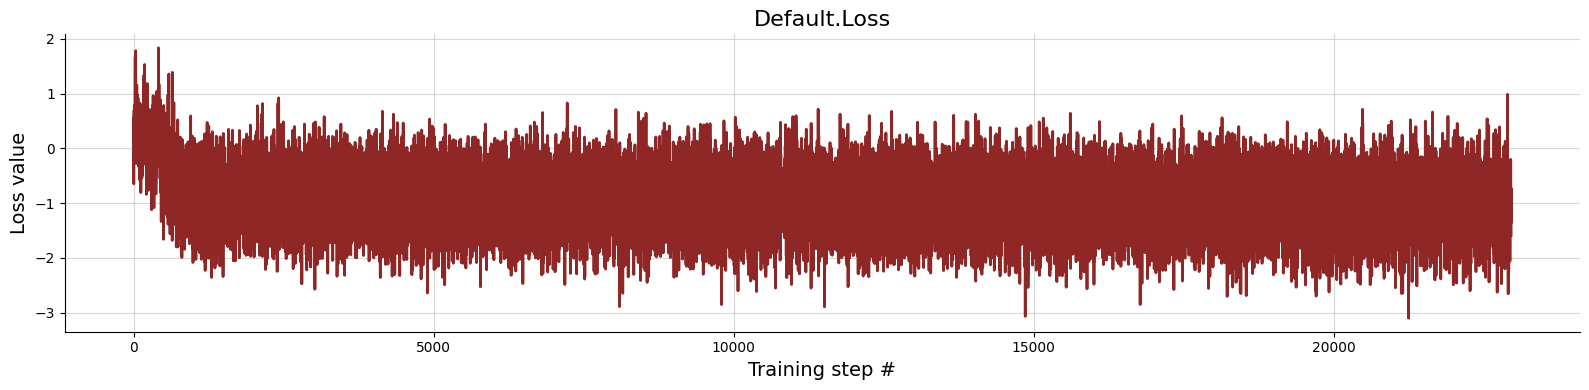

In [54]:
f = diag.plot_losses(h)

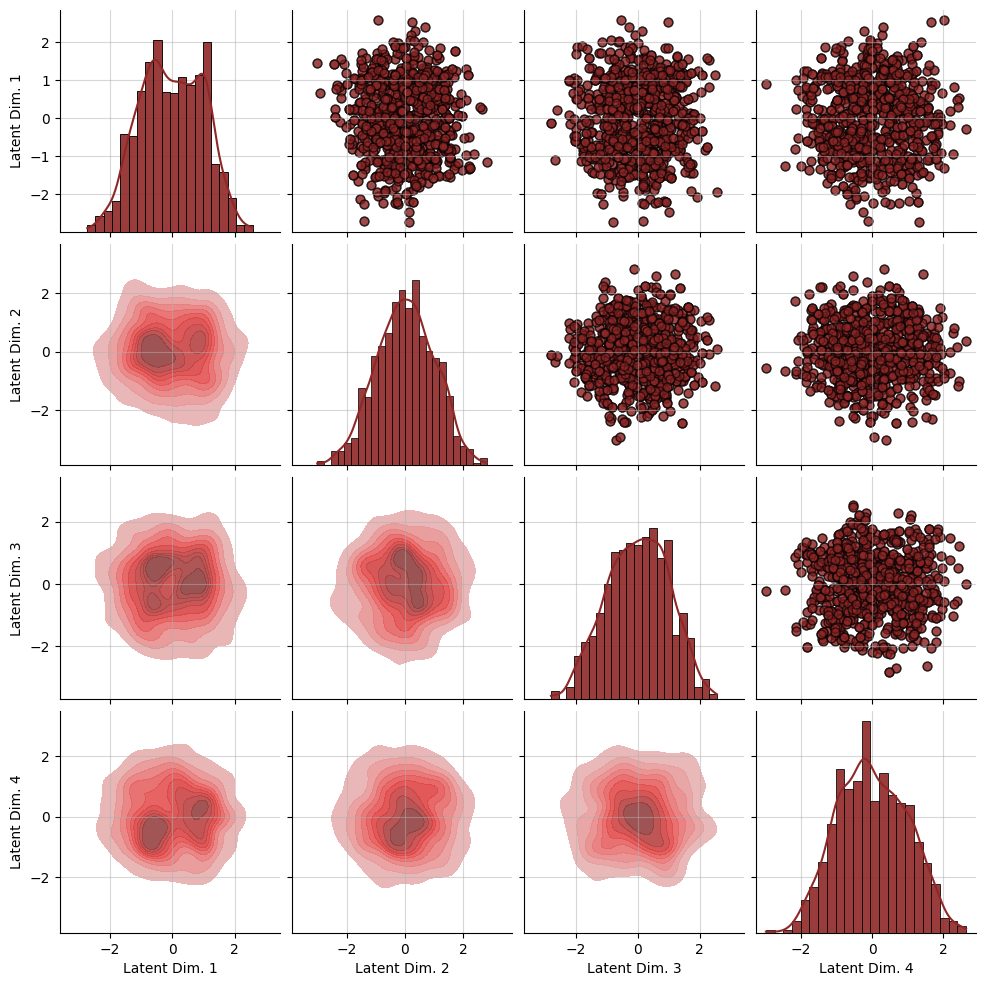

In [55]:
f = trainer.diagnose_latent2d()

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 19.                    Confidence intervals might be unreliable!


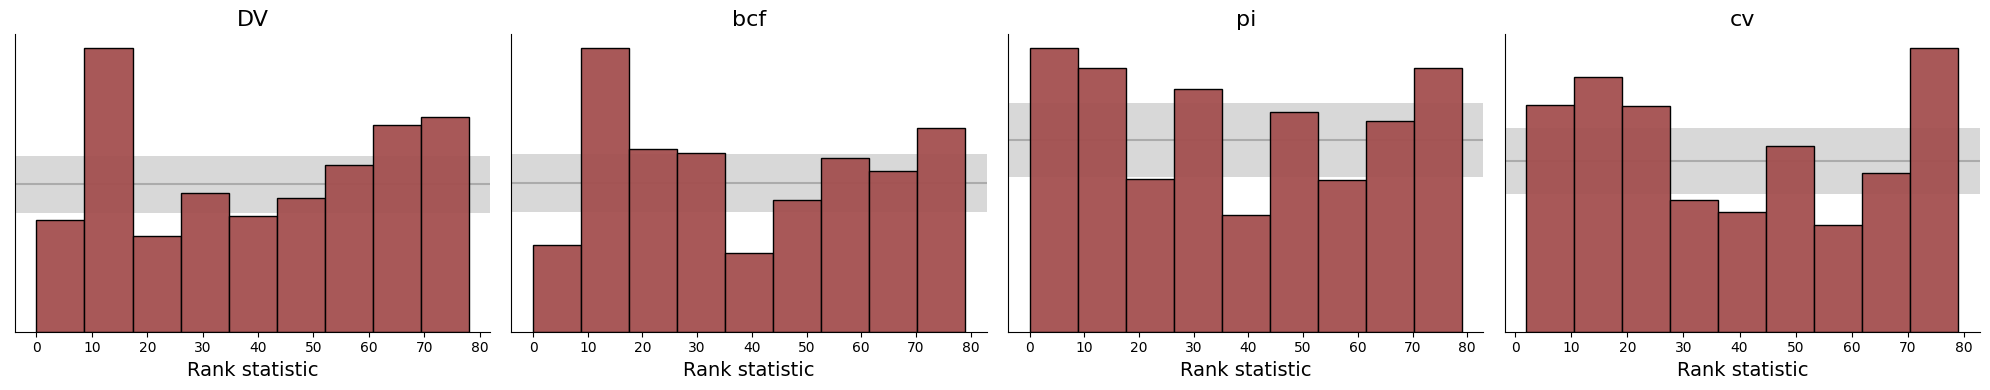

In [56]:
f = trainer.diagnose_sbc_histograms()

In [1]:
# Generate some validation data
validation_sims = trainer.configurator(model(batch_size=100))

# Generate posterior draws for all simulations
post_samples = amortizer.sample(validation_sims, n_samples=500)

# Create ECDF plot
f = diag.plot_sbc_ecdf(post_samples, validation_sims['parameters'])

NameError: name 'trainer' is not defined

In [ ]:
validation_sims = configure_input(model(batch_size=100))

/home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.6_bcf-0.6634742171745561_cv-0.7941072021091526_pi-0.5390777608652279


3674.66s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3679.85s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.6_bcf-0.6634742171745561_cv-0.7941072021091526_pi-0.5390777608652279
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.6_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461010
Random seed of thread 14 = 8873590
Random seed of thread 7 = 3301450
Random seed of thread 12 = 5327036
Random seed of thread 2 = 7640604
Random seed of thread 1 = 5934622
Random seed of thread 11 = 7935848
Random seed of thread 8 = 3517686
Random seed of thread 3 = 4904069
Random seed of thread 6 = 1961736
Random seed of thread 13 = 7000754
Random seed of thread 5 = 5907508
Random seed of thread 10 = 5762311
Random seed of thread 15 = 8834891
Random seed of thread 4 = 8778302
Random seed of thread 9 = 1804624
Registering Symbol space of linktype LocationLink 

3687.10s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3692.29s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.0_bcf-0.8444363859132252_cv-0.4756547022323249_pi-0.7275724145557062
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.0_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461022
Random seed of thread 6 = 1318994
Random seed of thread 12 = 3818700
Random seed of thread 8 = 699329
Random seed of thread 14 = 7205172
Random seed of thread 10 = 6963187
Random seed of thread 4 = 9218951
Random seed of thread 1 = 5802738
Random seed of thread 13 = 8866564
Random seed of thread 7 = 7510684
Random seed of thread 2 = 4149762
Random seed of thread 15 = 3701977
Random seed of thread 3 = 3612580
Random seed of thread 11 = 5266603
Random seed of thread 9 = 7425950
Random seed of thread 5 = 9914803
Registering Symbol space of linktype LocationLink i

3699.45s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3704.64s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-1.0_bcf-0.13861707517436211_cv-0.821507885045239_pi-0.6076645063494647
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-1.0_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461035
Random seed of thread 3 = 7845078
Random seed of thread 7 = 1445385
Random seed of thread 13 = 1590008
Random seed of thread 1 = 993654
Random seed of thread 15 = 9872511
Random seed of thread 12 = 8507050
Random seed of thread 6 = 4916609
Random seed of thread 2 = 630110
Random seed of thread 5 = 4928174
Random seed of thread 14 = 6718604
Random seed of thread 11 = 6922900
Random seed of thread 9 = 31302
Random seed of thread 4 = 8810796
Random seed of thread 10 = 7583242
Random seed of thread 8 = 878999
Registering Symbol space of linktype LocationLink in Sc

3711.86s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3717.06s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-1.0_bcf-0.5529429541371765_cv-0.17181299981407278_pi-0.9539327683069277
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-1.0_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461047
Random seed of thread 8 = 3576992
Random seed of thread 4 = 3458246
Random seed of thread 15 = 3567554
Random seed of thread 2 = 7532274
Random seed of thread 13 = 9750588
Random seed of thread 11 = 1249218
Random seed of thread 6 = 4209149
Random seed of thread 12 = 8312624
Random seed of thread 10 = 9623856
Random seed of thread 1 = 6443877
Random seed of thread 5 = 5544859
Random seed of thread 3 = 6608181
Random seed of thread 7 = 5276643
Random seed of thread 9 = 4179359
Random seed of thread 14 = 4355162
Registering Symbol space of linktype LocationLink

3724.26s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3729.45s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.6_bcf-0.3173063077707275_cv-0.10542693906889596_pi-0.7826803489193048
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.6_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461060
Random seed of thread 12 = 452686
Random seed of thread 14 = 1330929
Random seed of thread 5 = 1352523
Random seed of thread 1 = 661184
Random seed of thread 13 = 136180
Random seed of thread 10 = 6894665
Random seed of thread 3 = 3814289
Random seed of thread 6 = 7127464
Random seed of thread 7 = 1058770
Random seed of thread 11 = 5220507
Random seed of thread 4 = 5346720
Random seed of thread 8 = 929894
Random seed of thread 15 = 7782408
Random seed of thread 9 = 6254785
Random seed of thread 2 = 3345012
Registering Symbol space of linktype LocationLink in 

3736.67s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3741.86s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.8_bcf-0.631983011599437_cv-0.6086371461532746_pi-0.5233683450861485
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.8_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461072
Random seed of thread 8 = 9424403
Random seed of thread 3 = 2262285
Random seed of thread 7 = 1266795
Random seed of thread 13 = 5566041
Random seed of thread 11 = 1519581
Random seed of thread 5 = 6599753
Random seed of thread 2 = 9024614
Random seed of thread 14 = 6653709
Random seed of thread 1 = 5642997
Random seed of thread 12 = 240841
Random seed of thread 10 = 9705473
Random seed of thread 9 = 7306099
Random seed of thread 4 = 9870627
Random seed of thread 15 = 647224
Random seed of thread 6 = 993588
Registering Symbol space of linktype LocationLink in S

3749.03s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3754.22s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.6_bcf-0.04992952786058948_cv-0.6559796087437075_pi-0.8827449176153227
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.6_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461084
Random seed of thread 8 = 4498890
Random seed of thread 6 = 9626052
Random seed of thread 14 = 9014616
Random seed of thread 2 = 5069874
Random seed of thread 4 = 9235776
Random seed of thread 10 = 9355741
Random seed of thread 12 = 2842461
Random seed of thread 5 = 5019292
Random seed of thread 9 = 2865521
Random seed of thread 7 = 58937
Random seed of thread 11 = 7576600
Random seed of thread 15 = 1500599
Random seed of thread 3 = 6631223
Random seed of thread 1 = 6946641
Random seed of thread 13 = 8827021
Registering Symbol space of linktype LocationLink i

3761.51s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3766.70s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.8_bcf-0.6377061324544288_cv-0.13776474262055724_pi-0.17512829406305172
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.8_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461097
Random seed of thread 8 = 2747491
Random seed of thread 5 = 3364081
Random seed of thread 11 = 728346
Random seed of thread 13 = 3874760
Random seed of thread 3 = 8739617
Random seed of thread 10 = 9464920
Random seed of thread 6 = 5864006
Random seed of thread 14 = 1661472
Random seed of thread 2 = 8815625
Random seed of thread 1 = 4003600
Random seed of thread 4 = 6525184
Random seed of thread 7 = 1750039
Random seed of thread 15 = 967071
Random seed of thread 12 = 8302960
Random seed of thread 9 = 2072262
Registering Symbol space of linktype LocationLink 

3773.90s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3779.10s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.8_bcf-0.27830454480083666_cv-0.7421054497801086_pi-0.9983486573447363
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.8_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461109
Random seed of thread 7 = 7333881
Random seed of thread 15 = 1075308
Random seed of thread 10 = 4851811
Random seed of thread 3 = 6725595
Random seed of thread 1 = 4458102
Random seed of thread 13 = 6847052
Random seed of thread 11 = 5108592
Random seed of thread 5 = 2155532
Random seed of thread 12 = 7011023
Random seed of thread 9 = 9775377
Random seed of thread 14 = 5782918
Random seed of thread 8 = 1166373
Random seed of thread 4 = 2322811
Random seed of thread 2 = 7562079
Random seed of thread 6 = 2984494
Registering Symbol space of linktype LocationLink

3786.50s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3791.69s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-1.0_bcf-0.694566958249542_cv-0.08691580442187515_pi-0.18774149420826136
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-1.0_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461122
Random seed of thread 6 = 962251
Random seed of thread 12 = 1153668
Random seed of thread 7 = 2060109
Random seed of thread 10 = 6496050
Random seed of thread 4 = 7047558
Random seed of thread 2 = 6024683
Random seed of thread 8 = 433140
Random seed of thread 15 = 2929719
Random seed of thread 13 = 1852571
Random seed of thread 5 = 7409906
Random seed of thread 11 = 9045496
Random seed of thread 14 = 4447791
Random seed of thread 1 = 3181185
Random seed of thread 9 = 1115815
Random seed of thread 3 = 8388658
Registering Symbol space of linktype LocationLink i

3798.93s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3804.12s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-1.0_bcf-0.8605764381367638_cv-0.42982278761356413_pi-0.38479552880371276
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-1.0_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461134
Random seed of thread 7 = 7290277
Random seed of thread 2 = 8814613
Random seed of thread 14 = 8852929
Random seed of thread 10 = 7616086
Random seed of thread 4 = 6708499
Random seed of thread 9 = 3701311
Random seed of thread 12 = 147782
Random seed of thread 8 = 2958644
Random seed of thread 11 = 7737787
Random seed of thread 3 = 7777665
Random seed of thread 5 = 4818583
Random seed of thread 13 = 8110358
Random seed of thread 6 = 5160423
Random seed of thread 1 = 9052370
Random seed of thread 15 = 2782974
Registering Symbol space of linktype LocationLink

3811.40s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3816.59s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.0_bcf-0.7535993922341212_cv-0.6568139467088099_pi-0.8352804519999286
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.0_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461147
Random seed of thread 14 = 3331551
Random seed of thread 1 = 9669952
Random seed of thread 4 = 3650555
Random seed of thread 2 = 8118273
Random seed of thread 8 = 8159293
Random seed of thread 7 = 1558920
Random seed of thread 12 = 4690206
Random seed of thread 6 = 5140493
Random seed of thread 13 = 5813664
Random seed of thread 15 = 5403785
Random seed of thread 3 = 1197147
Random seed of thread 9 = 1673333
Random seed of thread 11 = 5342466
Random seed of thread 5 = 6794371
Random seed of thread 10 = 3432747
Registering Symbol space of linktype LocationLink 

3823.76s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3828.95s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.8_bcf-0.0789483986238741_cv-0.9545755911789646_pi-0.31735133606876675
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.8_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461159
Random seed of thread 9 = 5951508
Random seed of thread 5 = 7408933
Random seed of thread 14 = 8120659
Random seed of thread 11 = 2787815
Random seed of thread 10 = 1233239
Random seed of thread 13 = 8020304
Random seed of thread 3 = 9138557
Random seed of thread 8 = 5319284
Random seed of thread 1 = 5819382
Random seed of thread 4 = 5362815
Random seed of thread 7 = 9549203
Random seed of thread 15 = 8371322
Random seed of thread 6 = 5704063
Random seed of thread 2 = 7763560
Random seed of thread 12 = 7913984
Registering Symbol space of linktype LocationLink

3836.16s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3841.34s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.8_bcf-0.20991944860511583_cv-0.46452841661771904_pi-0.14137631422311567
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.8_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461171
Random seed of thread 14 = 8947387
Random seed of thread 9 = 6142615
Random seed of thread 7 = 2118215
Random seed of thread 6 = 7634631
Random seed of thread 2 = 2989544
Random seed of thread 12 = 9129631
Random seed of thread 4 = 8705571
Random seed of thread 10 = 9313369
Random seed of thread 15 = 2724083
Random seed of thread 13 = 8306292
Random seed of thread 5 = 786809
Random seed of thread 3 = 4357391
Random seed of thread 11 = 5918355
Random seed of thread 1 = 459926
Random seed of thread 8 = 1644660
Registering Symbol space of linktype LocationLink

3848.63s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3853.82s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.8_bcf-0.14564736745328197_cv-0.2753569049783274_pi-0.05435714342179148
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.8_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461184
Random seed of thread 7 = 3733102
Random seed of thread 10 = 3151891
Random seed of thread 12 = 4818729
Random seed of thread 2 = 1021442
Random seed of thread 15 = 409168
Random seed of thread 9 = 5777117
Random seed of thread 4 = 1861773
Random seed of thread 11 = 7556396
Random seed of thread 8 = 3048273
Random seed of thread 13 = 2928415
Random seed of thread 14 = 335111
Random seed of thread 6 = 4812790
Random seed of thread 1 = 4895146
Random seed of thread 5 = 6381162
Random seed of thread 3 = 6761936
Registering Symbol space of linktype LocationLink 

3861.03s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3866.22s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.4_bcf-0.22776101798562526_cv-0.023227562431526842_pi-0.4114783457793902
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.4_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461196
Random seed of thread 14 = 2747445
Random seed of thread 6 = 8696913
Random seed of thread 9 = 3145122
Random seed of thread 4 = 6565149
Random seed of thread 1 = 1610406
Random seed of thread 8 = 2743841
Random seed of thread 12 = 710976
Random seed of thread 2 = 9174288
Random seed of thread 7 = 9556037
Random seed of thread 11 = 4155582
Random seed of thread 10 = 2201390
Random seed of thread 13 = 8734472
Random seed of thread 5 = 394816
Random seed of thread 3 = 3997041
Random seed of thread 15 = 983734
Registering Symbol space of linktype LocationLink 

3873.43s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3878.62s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.8_bcf-0.6347119097022589_cv-0.8226885069950343_pi-0.07892427029345737
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.8_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461209
Random seed of thread 6 = 1501212
Random seed of thread 13 = 2736788
Random seed of thread 7 = 1183500
Random seed of thread 2 = 8214633
Random seed of thread 15 = 5482925
Random seed of thread 4 = 5644033
Random seed of thread 9 = 2661988
Random seed of thread 11 = 549107
Random seed of thread 8 = 5371965
Random seed of thread 12 = 8050688
Random seed of thread 5 = 4044923
Random seed of thread 3 = 8291132
Random seed of thread 14 = 2727295
Random seed of thread 10 = 6750958
Random seed of thread 1 = 1765571
Registering Symbol space of linktype LocationLink 

3885.87s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3891.06s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.0_bcf-0.41043516326976204_cv-0.814314609803169_pi-0.3460227510076258
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.0_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461221
Random seed of thread 9 = 136088
Random seed of thread 12 = 2320395
Random seed of thread 2 = 2732057
Random seed of thread 6 = 4939382
Random seed of thread 4 = 8893639
Random seed of thread 7 = 2552072
Random seed of thread 14 = 6649512
Random seed of thread 10 = 6271695
Random seed of thread 11 = 3299434
Random seed of thread 13 = 951897
Random seed of thread 1 = 4750414
Random seed of thread 15 = 514222
Random seed of thread 8 = 4829570
Random seed of thread 3 = 2484820
Random seed of thread 5 = 9586264
Registering Symbol space of linktype LocationLink in 

3898.22s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3903.42s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.0_bcf-0.22213056854908822_cv-0.4284848979393399_pi-0.12256977947898352
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.0_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461233
Random seed of thread 12 = 5791344
Random seed of thread 1 = 3469936
Random seed of thread 5 = 4283930
Random seed of thread 11 = 4758641
Random seed of thread 14 = 888711
Random seed of thread 3 = 542843
Random seed of thread 6 = 8149955
Random seed of thread 9 = 49145
Random seed of thread 7 = 7080774
Random seed of thread 2 = 8473261
Random seed of thread 13 = 3306117
Random seed of thread 4 = 6401951
Random seed of thread 8 = 5278093
Random seed of thread 10 = 2456261
Random seed of thread 15 = 2395296
Registering Symbol space of linktype LocationLink in

3910.60s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3915.79s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.6_bcf-0.8399322436995039_cv-0.924487642792617_pi-0.7983313632818916
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.6_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461246
Random seed of thread 12 = 9810022
Random seed of thread 7 = 9665739
Random seed of thread 4 = 2724802
Random seed of thread 6 = 458967
Random seed of thread 14 = 7795486
Random seed of thread 9 = 5835345
Random seed of thread 2 = 7244427
Random seed of thread 11 = 9930900
Random seed of thread 8 = 5555977
Random seed of thread 3 = 3425692
Random seed of thread 5 = 2732642
Random seed of thread 10 = 3631179
Random seed of thread 1 = 7699900
Random seed of thread 15 = 9041144
Random seed of thread 13 = 945919
Registering Symbol space of linktype LocationLink in 

3923.04s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3928.24s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.0_bcf-0.7719054219443778_cv-0.12966350858942494_pi-0.4069681903727918
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.0_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461258
Random seed of thread 8 = 823136
Random seed of thread 9 = 2133441
Random seed of thread 2 = 4680361
Random seed of thread 1 = 4167890
Random seed of thread 6 = 6880724
Random seed of thread 10 = 677335
Random seed of thread 15 = 5966763
Random seed of thread 3 = 8533719
Random seed of thread 5 = 1524649
Random seed of thread 12 = 2207670
Random seed of thread 11 = 4947419
Random seed of thread 4 = 581119
Random seed of thread 14 = 3859761
Random seed of thread 13 = 1559746
Random seed of thread 7 = 7168208
Registering Symbol space of linktype LocationLink in

3935.38s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3940.57s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.0_bcf-0.7562491582514926_cv-0.6663275575097851_pi-0.6998135916384063
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.0_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461271
Random seed of thread 2 = 1569987
Random seed of thread 11 = 3923543
Random seed of thread 12 = 7749587
Random seed of thread 14 = 8274113
Random seed of thread 4 = 9998228
Random seed of thread 7 = 3328852
Random seed of thread 9 = 4350098
Random seed of thread 3 = 4742362
Random seed of thread 10 = 3380223
Random seed of thread 8 = 4323969
Random seed of thread 6 = 8795526
Random seed of thread 1 = 1909880
Random seed of thread 15 = 4459218
Random seed of thread 13 = 8234574
Random seed of thread 5 = 6957211
Registering Symbol space of linktype LocationLink 

3947.77s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3952.96s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.6_bcf-0.8870278192018878_cv-0.6099210390412085_pi-0.06004798276041058
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.6_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461283
Random seed of thread 10 = 4408881
Random seed of thread 12 = 7539780
Random seed of thread 2 = 5552706
Random seed of thread 9 = 8180230
Random seed of thread 6 = 6299124
Random seed of thread 15 = 8088354
Random seed of thread 4 = 7731262
Random seed of thread 3 = 9824545
Random seed of thread 13 = 4600477
Random seed of thread 1 = 5625561
Random seed of thread 8 = 5888884
Random seed of thread 7 = 2101697
Random seed of thread 11 = 1291972
Random seed of thread 5 = 287285
Random seed of thread 14 = 5789433
Registering Symbol space of linktype LocationLink 

3960.19s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3965.39s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.2_bcf-0.7267608009261972_cv-0.9115232209368537_pi-0.37856529384225124
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.2_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461295
Random seed of thread 6 = 8877429
Random seed of thread 4 = 4650485
Random seed of thread 2 = 4508503
Random seed of thread 11 = 9610506
Random seed of thread 5 = 2087981
Random seed of thread 9 = 8222028
Random seed of thread 13 = 6632110
Random seed of thread 12 = 154005
Random seed of thread 14 = 7625410
Random seed of thread 15 = 832745
Random seed of thread 10 = 9356061
Random seed of thread 1 = 7085191
Random seed of thread 3 = 3705531
Random seed of thread 8 = 7024612
Random seed of thread 7 = 9734615
Registering Symbol space of linktype LocationLink i

3972.58s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3977.77s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.8_bcf-0.231442099460648_cv-0.8454347926102621_pi-0.7263273235938689
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.8_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461308
Random seed of thread 6 = 7504738
Random seed of thread 2 = 6798783
Random seed of thread 15 = 2983418
Random seed of thread 9 = 3397103
Random seed of thread 13 = 777671
Random seed of thread 4 = 714292
Random seed of thread 7 = 5943642
Random seed of thread 11 = 3367052
Random seed of thread 14 = 6967709
Random seed of thread 5 = 7603071
Random seed of thread 12 = 2402386
Random seed of thread 1 = 171711
Random seed of thread 8 = 294952
Random seed of thread 3 = 4457406
Random seed of thread 10 = 4271312
Registering Symbol space of linktype LocationLink in Sc

3985.01s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3990.21s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.2_bcf-0.684671933056103_cv-0.982117508829826_pi-0.3503236913300728
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.2_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461320
Random seed of thread 5 = 9173023
Random seed of thread 1 = 5477881
Random seed of thread 6 = 3504022
Random seed of thread 4 = 2877453
Random seed of thread 8 = 9161781
Random seed of thread 14 = 2981462
Random seed of thread 13 = 2254882
Random seed of thread 12 = 5618882
Random seed of thread 15 = 8400218
Random seed of thread 3 = 356229
Random seed of thread 2 = 6658601
Random seed of thread 10 = 510127
Random seed of thread 7 = 9583582
Random seed of thread 11 = 732897
Random seed of thread 9 = 9666511
Registering Symbol space of linktype LocationLink in Sc

3997.45s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4002.64s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.0_bcf-0.33684513144281497_cv-0.9213406224523552_pi-0.47427958823763394
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.0_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461333
Random seed of thread 14 = 3235066
Random seed of thread 13 = 6679238
Random seed of thread 6 = 1967938
Random seed of thread 4 = 6956169
Random seed of thread 2 = 8083891
Random seed of thread 11 = 1216184
Random seed of thread 3 = 5820164
Random seed of thread 12 = 6377005
Random seed of thread 9 = 6212415
Random seed of thread 7 = 6102849
Random seed of thread 15 = 8723044
Random seed of thread 1 = 3755053
Random seed of thread 10 = 8634709
Random seed of thread 5 = 7312160
Random seed of thread 8 = 8705238
Registering Symbol space of linktype LocationLin

4009.78s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4014.97s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.8_bcf-0.3708197462250681_cv-0.8552963842129193_pi-0.8790214179532239
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.8_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461345
Random seed of thread 11 = 4827293
Random seed of thread 4 = 4367156
Random seed of thread 2 = 817410
Random seed of thread 8 = 5416256
Random seed of thread 9 = 319250
Random seed of thread 14 = 1037163
Random seed of thread 15 = 1188014
Random seed of thread 6 = 1105013
Random seed of thread 5 = 9763366
Random seed of thread 7 = 8726771
Random seed of thread 13 = 8171770
Random seed of thread 10 = 9599184
Random seed of thread 3 = 4252513
Random seed of thread 12 = 7385223
Random seed of thread 1 = 7842157
Registering Symbol space of linktype LocationLink in

4022.19s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4027.37s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.6_bcf-0.5250424992522326_cv-0.3420948709593439_pi-0.1914845317101837
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.6_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461357
Random seed of thread 4 = 4588152
Random seed of thread 2 = 1613810
Random seed of thread 12 = 8062343
Random seed of thread 9 = 3897153
Random seed of thread 10 = 3574755
Random seed of thread 14 = 315339
Random seed of thread 7 = 3490989
Random seed of thread 5 = 6081334
Random seed of thread 1 = 7580498
Random seed of thread 11 = 2028452
Random seed of thread 15 = 8219164
Random seed of thread 8 = 3327093
Random seed of thread 3 = 5897236
Random seed of thread 13 = 1398414
Random seed of thread 6 = 8461567
Registering Symbol space of linktype LocationLink i

4034.58s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4039.77s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.4_bcf-0.6028054313952473_cv-0.03195481244390151_pi-0.9474234143627267
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.4_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461370
Random seed of thread 9 = 9191591
Random seed of thread 7 = 2507572
Random seed of thread 1 = 84919
Random seed of thread 6 = 7333421
Random seed of thread 12 = 3042665
Random seed of thread 14 = 1380387
Random seed of thread 4 = 8500835
Random seed of thread 11 = 6656717
Random seed of thread 3 = 8402589
Random seed of thread 2 = 8735157
Random seed of thread 15 = 8930854
Random seed of thread 5 = 8474402
Random seed of thread 10 = 6317675
Random seed of thread 8 = 6976886
Random seed of thread 13 = 2322507
Registering Symbol space of linktype LocationLink i

4046.95s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4052.15s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.8_bcf-0.24356623987055054_cv-0.8010235739952439_pi-0.6031158949113824
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.8_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461382
Random seed of thread 7 = 8147867
Random seed of thread 14 = 4398501
Random seed of thread 2 = 9790173
Random seed of thread 12 = 2162968
Random seed of thread 10 = 4377517
Random seed of thread 4 = 8119365
Random seed of thread 8 = 3163519
Random seed of thread 11 = 3279629
Random seed of thread 15 = 9493008
Random seed of thread 13 = 8361650
Random seed of thread 5 = 8016733
Random seed of thread 3 = 9499151
Random seed of thread 6 = 3016312
Random seed of thread 9 = 361607
Random seed of thread 1 = 1504073
Registering Symbol space of linktype LocationLink 

4059.38s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4064.57s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.0_bcf-0.5311456426009649_cv-0.8882165289186319_pi-0.3411622092448138
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.0_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461395
Random seed of thread 7 = 1005654
Random seed of thread 3 = 4323705
Random seed of thread 13 = 4747404
Random seed of thread 11 = 6901989
Random seed of thread 15 = 4090658
Random seed of thread 5 = 7680501
Random seed of thread 10 = 6804500
Random seed of thread 8 = 4365030
Random seed of thread 1 = 3817827
Random seed of thread 6 = 200132
Random seed of thread 12 = 5141674
Random seed of thread 14 = 734609
Random seed of thread 2 = 9680790
Random seed of thread 4 = 2141930
Random seed of thread 9 = 5889203
Registering Symbol space of linktype LocationLink in

4071.75s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4076.94s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-1.0_bcf-0.8499206577156396_cv-0.34554260889996374_pi-0.09836148610657919
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-1.0_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461407
Random seed of thread 4 = 9025616
Random seed of thread 11 = 4910603
Random seed of thread 2 = 770449
Random seed of thread 14 = 3119761
Random seed of thread 9 = 6106633
Random seed of thread 6 = 9517998
Random seed of thread 12 = 941431
Random seed of thread 1 = 6961869
Random seed of thread 13 = 4274946
Random seed of thread 15 = 7168736
Random seed of thread 5 = 1205762
Random seed of thread 3 = 3196326
Random seed of thread 8 = 9978834
Random seed of thread 10 = 875508
Random seed of thread 7 = 5206458
Registering Symbol space of linktype LocationLink i

4084.16s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4089.36s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-1.0_bcf-0.43532533162935017_cv-0.23026483020216035_pi-0.7265662112306029
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-1.0_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461419
Random seed of thread 8 = 409706
Random seed of thread 6 = 469402
Random seed of thread 15 = 1354765
Random seed of thread 13 = 4631860
Random seed of thread 2 = 520025
Random seed of thread 4 = 2933339
Random seed of thread 9 = 3686834
Random seed of thread 7 = 7159099
Random seed of thread 11 = 6037764
Random seed of thread 14 = 6993048
Random seed of thread 5 = 8399817
Random seed of thread 3 = 6948544
Random seed of thread 10 = 956327
Random seed of thread 1 = 5379822
Random seed of thread 12 = 3498922
Registering Symbol space of linktype LocationLink in

4096.52s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4101.72s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.4_bcf-0.45515357500289083_cv-0.34921915952722066_pi-0.9317305226209169
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.4_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461432
Random seed of thread 8 = 2722665
Random seed of thread 10 = 9512693
Random seed of thread 13 = 2866258
Random seed of thread 7 = 7127489
Random seed of thread 9 = 6081158
Random seed of thread 6 = 9308458
Random seed of thread 12 = 8786419
Random seed of thread 2 = 8400735
Random seed of thread 4 = 221161
Random seed of thread 5 = 7519640
Random seed of thread 1 = 7325785
Random seed of thread 3 = 4645321
Random seed of thread 14 = 8441369
Random seed of thread 15 = 9278426
Random seed of thread 11 = 6063576
Registering Symbol space of linktype LocationLink

4108.96s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4114.14s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_online/DV-0.2_bcf-0.5938553086261659_cv-0.5676444324060353_pi-0.9705264244137127
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.2_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1662461444
Random seed of thread 6 = 8949692
Random seed of thread 5 = 6183876
Random seed of thread 11 = 657466
Random seed of thread 1 = 2426076
Random seed of thread 3 = 94643
Random seed of thread 13 = 2979613
Random seed of thread 7 = 5710179
Random seed of thread 2 = 1268520
Random seed of thread 14 = 5774724
Random seed of thread 10 = 8997091
Random seed of thread 4 = 6441256
Random seed of thread 8 = 9099492
Random seed of thread 12 = 5477543
Random seed of thread 15 = 2908995
Random seed of thread 9 = 3905136
Registering Symbol space of linktype LocationLink in 

UnboundLocalError: local variable 'child' referenced before assignment

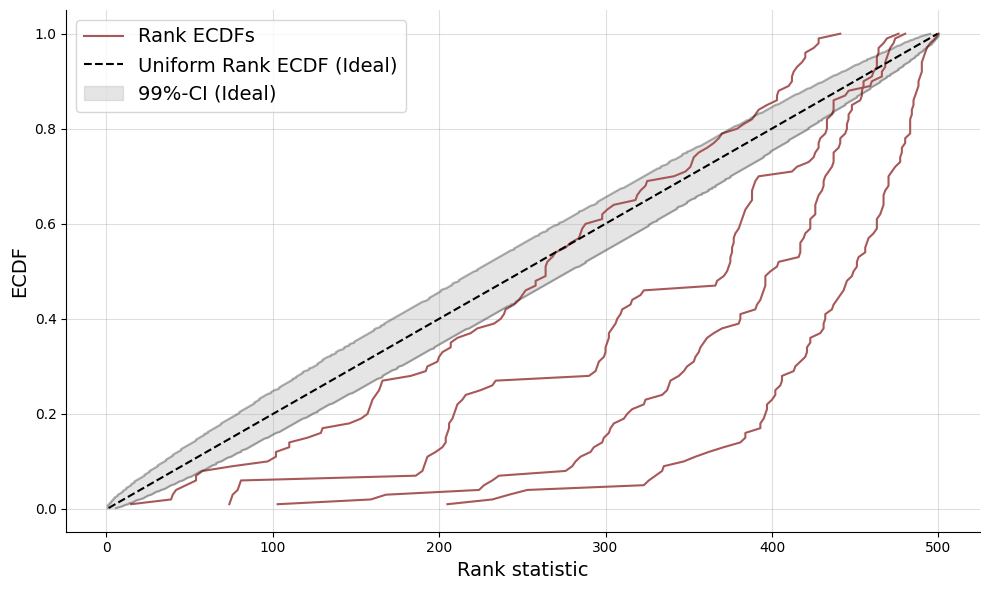

In [ ]:
# Generate posterior draws for all simulations
post_samples = amortizer.sample(validation_sims, n_samples=500)

# Create ECDF plot
f = diag.plot_sbc_ecdf(post_samples, validation_sims['parameters'])

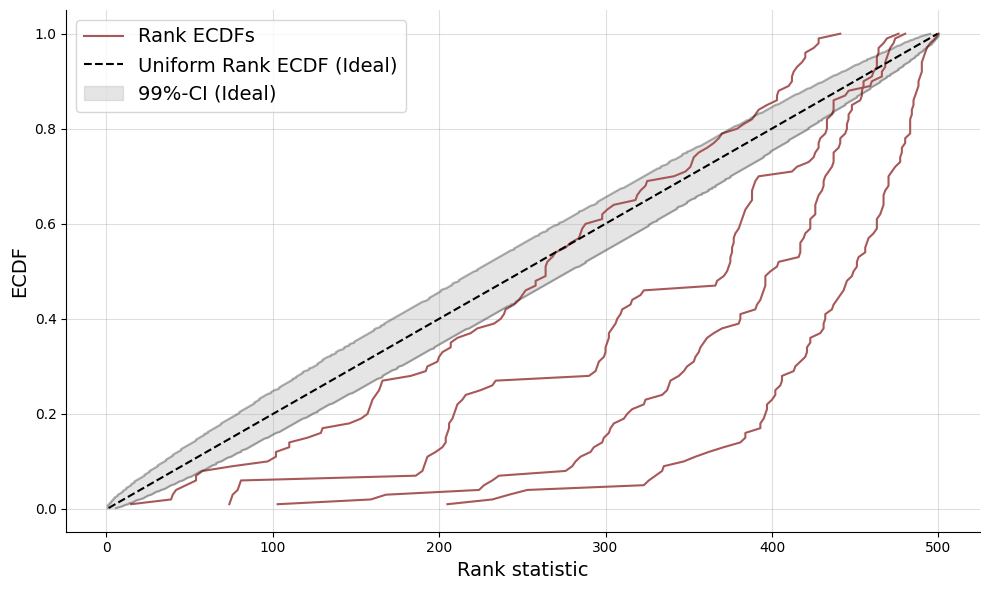

In [ ]:
f

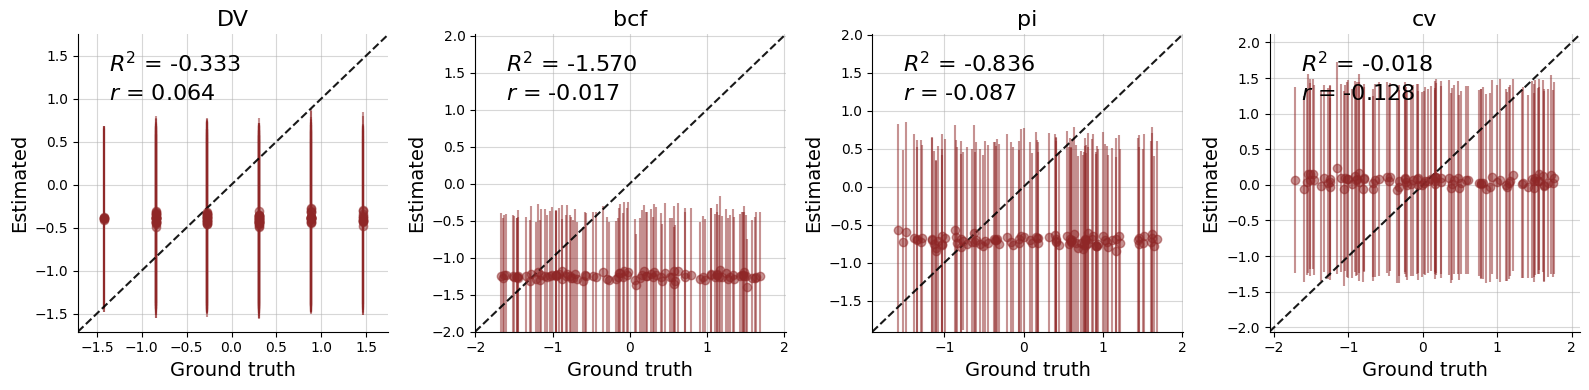

In [ ]:
f = diag.plot_recovery(post_samples, validation_sims['parameters'], param_names=prior.param_names)